# Classifier Training

## Initial Setup

In [20]:
# Imports
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import gc
from torchvision.models.resnet import resnet18
from torchsummary import summary
from tqdm.auto import tqdm
import torch_directml
from dataset import TEST_DATASET, TRAIN_DATASET, get_elements_from_indexes, LABELS
from datasets import load_dataset
from collections import OrderedDict
from segmentation.k_means import kmeans, KmeansFlags, KmeansTermCrit, KmeansTermOpt
from improving.filtering import conv2d
import cv2
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns

In [24]:
# MatPlotLib Configuration
%matplotlib 
plt.ioff()

In [4]:
# Set device
dml = torch_directml.device()

In [5]:
# Functions
# Plot single-channel images with a fixed configuration
def draw_grayscale_image(image, ax):
    ax.imshow(image, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    
# Clear output and then execute decorator
def clear_and_execute(func):
    def wrapper(*args, **kwargs):
        clear_output()
        return func(*args, **kwargs)
    return wrapper

# Image pre-processing
# Filter definition
epsilon = 0.1
sigma = 3
gaussianDim = int(np.ceil(np.sqrt(-2 * sigma ** 2 * np.log(epsilon * sigma * np.sqrt(2 * np.pi)))))
gaussianKernel1D = cv2.getGaussianKernel(gaussianDim, sigma)
gaussianKernel = np.outer(gaussianKernel1D, gaussianKernel1D)
@clear_and_execute
def process_element(element):
    image = element[0]
    label = element[1]
    filtered_image = conv2d(image, gaussianKernel)
    compactness, labels, centers = kmeans(
        filtered_image.flatten(), 3, 
        criteria=KmeansTermCrit(KmeansTermOpt.BOTH, 20, 0.5),
        flags=KmeansFlags.KMEANS_PP_CENTERS, attempts=5
    )
    centers = centers.astype(np.uint8)
    segmented_kmeans = centers[labels].reshape(image.shape)
    sorted_centers = sorted(centers)
    white_matter_idx = np.argmax(centers == sorted_centers[2])
    grey_matter_idx = np.argmax(centers == sorted_centers[1])
    segmented_white_matter = np.where(segmented_kmeans == centers[white_matter_idx], 1, 0).astype(np.uint8)
    segmented_grey_matter = np.where(segmented_kmeans == centers[grey_matter_idx], 1, 0).astype(np.uint8)
    return np.array((image, segmented_white_matter, segmented_grey_matter)), label

# Parallel processing of images
def parallel_processing(dataset_elements):
    dataset_length = len(dataset_elements)
    data = np.zeros((dataset_length, 3, *img_shape), dtype=np.uint8)
    labels = np.zeros((dataset_length,), dtype=np.uint8)
    results = Parallel(n_jobs=8)(delayed(process_element)(element) for element in tqdm(dataset_elements))
    for index in range(len(results)):
        data[index] = results[index][0]
        labels[index] = results[index][1]
    return data, labels.astype(np.uint8)

In [6]:
# Pre-processed dataset files
if not os.path.exists('pre_processed_dataset'):
    os.mkdir('pre_processed_dataset')
TRAIN_DATA_FILE = 'pre_processed_dataset/train.npy'
TRAIN_LABELS_FILE = 'pre_processed_dataset/train_labels.npy'
TEST_DATA_FILE = 'pre_processed_dataset/test.npy'
TEST_LABELS_FILE = 'pre_processed_dataset/test_labels.npy'

In [7]:
# Checkpoint folder creation
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

## Dataset Preprocessing

In [7]:
train_dataset = load_dataset(**TRAIN_DATASET)
train_dataset_length = len(train_dataset)
train_dataset_elements = get_elements_from_indexes(train_dataset, np.arange(len(train_dataset)))
img_shape = train_dataset_elements[0][0].shape
test_dataset = load_dataset(**TEST_DATASET)
test_dataset_elements = get_elements_from_indexes(test_dataset, np.arange(len(test_dataset)))

In [10]:
# Train Data Processing
train_data, train_labels = parallel_processing(train_dataset_elements)
print("Saving training data")
np.save(TRAIN_DATA_FILE, train_data)
np.save(TRAIN_LABELS_FILE, train_labels)

In [11]:
# Test Data Processing
test_data, test_labels = parallel_processing(test_dataset_elements)
print("Saving testing data")
np.save(TEST_DATA_FILE, test_data)
np.save(TEST_LABELS_FILE, test_labels)

  0%|          | 0/1280 [00:00<?, ?it/s]

Saving testing data


C:\Users\s1290226\AppData\Local\Temp\ipykernel_27524\1820417170.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sample_fig.show()


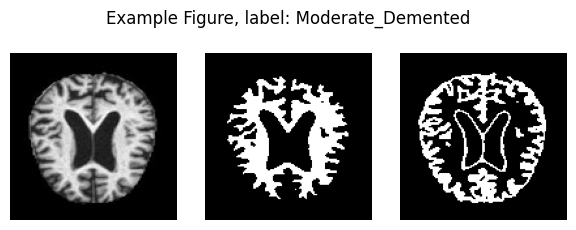

In [12]:
# Validate the results
train_data = np.load(TRAIN_DATA_FILE)
train_labels = np.load(TRAIN_LABELS_FILE)
random_index = np.random.randint(train_data.shape[0])
sample = train_data[random_index]
sample_image, sample_white_matter, sample_grey_matter = sample[0], sample[1], sample[2]
sample_label = train_labels[random_index]
if 'sample_fig' in globals():
    plt.close('Sample image')
sample_fig = plt.figure(figsize=(6, 2.3), num="Sample Image")
sample_axs = sample_fig.subplots(1, 3)
draw_grayscale_image(sample_image, sample_axs[0])
draw_grayscale_image(sample_white_matter * 255, sample_axs[1])
draw_grayscale_image(sample_grey_matter * 255, sample_axs[2])
sample_fig.suptitle(f"Example Figure, label: {LABELS[sample_label]}")
sample_fig.tight_layout()
sample_fig.show()

## Dataset Handlers & Dataloaders

In [8]:
# Dataset definition
class DatasetHandler(Dataset):
    def __init__(self, path_to_data: str, path_to_labels: str):
        self.data = torch.tensor(np.load(path_to_data), dtype=torch.float)
        self.data[:,0] /= 255 # Must be divided to be between 0 and 1
        labels = np.load(path_to_labels)
        self.labels = torch.zeros((len(labels), 4))
        for index in range(len(labels)):
            self.labels[index][labels[index]] = 1
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    def __len__(self):
        return len(self.data)

In [9]:
# Creation of dataloaders
train_dataset_handler = DatasetHandler(TRAIN_DATA_FILE, TRAIN_LABELS_FILE)
test_dataset_handler = DatasetHandler(TEST_DATA_FILE, TEST_LABELS_FILE)
batch_size_train = 16
batch_size_test = 32
n_workers = 4
train_dataloader = DataLoader(train_dataset_handler, batch_size=batch_size_train, shuffle=True,
                              num_workers=0, pin_memory=False)
test_dataloader = DataLoader(test_dataset_handler, batch_size=batch_size_test, shuffle=True,
                             num_workers=0, pin_memory=False)

## Module Initialization Functions

In [10]:
def init_weights(net, init='norm', gain=0.02, verbose: bool = True):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.validation_data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.validation_data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.validation_data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.validation_data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.validation_data, 1., gain)
            nn.init.constant_(m.bias.validation_data, 0.)
    net.apply(init_func)
    if verbose:
        print(f"Model initialized with {init} initialization.")
    return net


def init_model(model):
    model = init_weights(model)
    return model

## Architecture

### ResNet18

In [11]:
## ResNet Constitution
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        # In the init we declare the attributes of the block (mostly layers)
        super().__init__()
        self.downsample = downsample
        first_stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=first_stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=False)
        if downsample:
            # at the end of the residual block, we add the input to the output (skip connection)
            # but if we reduce the resolution of the output (with stride 2) the resolutions don't match
            # so we also have to reduce the resolution of the input
            # While reducing the resolution we also increase the number of channels
            # so we also use out_channels here to double the number of channels
            self.downsample_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            self.downsample_bn = nn.BatchNorm2d(out_channels)
    def forward(self, input):
        # the forward method calculates the result of the block
        conv1_out = self.conv1(input)
        bn1_out = self.bn1(conv1_out)
        relu1_out = self.relu1(bn1_out)
        conv2_out = self.conv2(relu1_out)
        bn2_out = self.bn2(conv2_out)
        if self.downsample:
            # half the width and height of input feature map if the block is downsampling
            # this also doubles the channel size
            input = self.downsample_conv(input)
            input = self.downsample_bn(input)
        # skip connection
        output = input + bn2_out
        return self.relu2(output)


class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            # conv halves width and height and creates 64 channel feature map
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # maxpool also halves width and height, channels stay the same
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    def forward(self, x):
        return self.sequential(x)


def get_classification_layer(in_channels, out_channels=1000):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        # standard imagenet has 1000 classes
        nn.Linear(in_features=in_channels, out_features=out_channels),
    )

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = Stem()
        self.stage2 = nn.Sequential(
            ResidualBlock(64, 64, downsample=False),
            ResidualBlock(64, 64, downsample=False)
        )
        self.stage3 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128, downsample=False)
        )
        self.stage4 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256, downsample=False)
        )
        self.stage5 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512, downsample=False)
        )
        self.classification_layer = get_classification_layer(512)
    def forward(self, input):
        stage1_output = self.stage1(input)
        stage2_output = self.stage2(stage1_output)
        stage3_output = self.stage3(stage2_output)
        stage4_output = self.stage4(stage3_output)
        stage5_output = self.stage5(stage4_output)
        classification = self.classification_layer(stage5_output)
        return classification

summary(ResNet18(), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
              Stem-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
    ResidualBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

### ResNet18 Initialization with Pre-Trained Weights

In [12]:
resnet_model = ResNet18()
pretrained_state_dict = resnet18( weights='IMAGENET1K_V1').state_dict()
new_state_dict = OrderedDict()
for key, value in zip(resnet_model.state_dict().keys(), pretrained_state_dict.values()):
    new_state_dict[key] = value
resnet_model.load_state_dict(new_state_dict)

<All keys matched successfully>

### ResNet18 without Prediction Head

In [13]:
resnet_skeleton = nn.Sequential(*list(resnet_model.children())[:-1])
summary(resnet_skeleton, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
              Stem-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
    ResidualBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

### Custom ResNet18 with Case-Specific Prediction Head

In [14]:
class CustomResNet18(nn.Module):
    def __init__(self, skeleton: nn.Module):
        super().__init__()
        self.skeleton = skeleton
        self.classifier = init_model(get_classification_layer(512, 4))
    def forward(self, input):
        return self.classifier(self.skeleton(input))
    def set_requires_grad_skeleton(self, requires_grad: bool = True):
        for param in self.skeleton.parameters():
            param.requires_grad = requires_grad

### Main Model Definition

In [15]:
class MainModel(nn.Module):
    def __init__(self, skeleton: nn.Module, lr=1e-3, beta1=0.9, beta2=0.999):
        super().__init__()
        self.device = dml
        self.net = CustomResNet18(skeleton).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.opt = optim.Adam(self.net.parameters(), lr=lr, betas=(beta1, beta2))
        self.input = None
        self.target = None
        self.prediction = None
        self.ce_loss = None
    def set_requires_grad(self, requires_grad=True):
        for p in self.net.parameters():
            p.requires_grad = requires_grad
    def setup_input(self, data):
        self.input = data[0].to(self.device)
        self.target = data[1].to(self.device)
    def forward(self):
        self.prediction = self.net(self.input)
    def backward(self):
        self.ce_loss = self.criterion(self.prediction, self.target)
        self.ce_loss.backward()
    def optimize(self):
        self.forward()
        self.net.train()
        self.opt.zero_grad()
        self.backward()
        self.opt.step()

## Training

### Model Initialization

In [15]:
from_checkpoint = True
classifier = MainModel(resnet_skeleton)
test_dataloader_iter = iter(test_dataloader)
if not from_checkpoint:
    last = 0
    classifier.net.set_requires_grad_skeleton(False)
else:
    classifier.net.set_requires_grad_skeleton(True)
    checkpoint = 8
    if checkpoint is None:
        last = 0
        classifier.load_state_dict(torch.load(os.path.join(rf'model.pth')))
    else:
        last = checkpoint
        classifier.load_state_dict(torch.load(os.path.join(rf'checkpoints/model_chckpt{checkpoint}.pth')))

Model initialized with norm initialization.


C:\Users\Josue\AppData\Local\Temp\ipykernel_21408\3088612028.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(os.path.join(rf'check

### Training Functions

In [16]:
class AverageMeter:
    def __init__(self):
        self.count, self.avg, self.sum = [0.] * 3
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count


def create_loss_meters():
    loss = AverageMeter()
    return {'ce_loss': loss}


def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def visualize(model, data, fig = None, ax = None):
    labels = np.argmax(data[1], axis=1)
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    predicted = np.argmax(functional.softmax(model.prediction.detach().cpu(), dim=1), axis=1)
    c_mat = confusion_matrix(labels, predicted, labels=np.arange(4))
    if ax is not None:
        ax.clear()
    categories = list(map(lambda x: x[1], sorted(list(LABELS.items()), key=lambda x: x[0])))
    sns.heatmap(c_mat/c_mat.sum(), 
                xticklabels=categories, yticklabels=categories,
                cmap='Blues',
                fmt='.2%',
                ax=ax,
                cbar=False)
    if fig is not None:
        fig.show()


def log_results(loss_meter_dict):
    log = ""
    for loss_name, loss_meter in loss_meter_dict.items():
        log += f"{loss_name}: {loss_meter.avg:.5f} "
    return log


def train_model(model: MainModel, train_dl: DataLoader, test_dl_iter,
                epochs: int = 100, display_every: int = 1, save_every: int = 5, 
                check_point_start: int = 0,
                fig = None, ax = None):
    check_point = check_point_start
    epoch_tqdm = tqdm(range(epochs), "Epochs", position=0, leave=True)
    for epoch in epoch_tqdm:
        loss_meter_dict = create_loss_meters() # function returning a dictionary of objects 
        batch_tqdm = tqdm(train_dl, "Batches", position=1, leave=False)
        for data in batch_tqdm:
            model.setup_input(data)
            model.optimize() # function updating the log objects
            update_losses(model, loss_meter_dict, count=32)
        batch_tqdm.close()
        results = log_results(loss_meter_dict)
        epoch_tqdm.set_description(f"{results}")
        if not (epoch + 1) % display_every:
            visualize(model, next(test_dl_iter), fig, ax) # function displaying the model's outputs
        if not (epoch + 1) % save_every:
            torch.save(model.state_dict(), os.path.join(rf'checkpoints/model_chckpt{check_point}.pth'))
            check_point = check_point + 1
    return check_point

### Validation Set Performance Supervision During Training

In [17]:
## Training Supervision
if 'train_figure' in globals():
    plt.close('Test Validation')
train_figure = plt.figure(num='Test Validation', figsize=(8,8))
train_ax = train_figure.subplots(1,1)
train_figure.show()

<IPython.core.display.Javascript object>

### Training

In [ ]:
# Training
# Warning: carefully set last in order to avoid loosing checkpoints
N_epochs = 10
Save_Every_N_epochs = 10
Show_Every_N_epochs = 1
last = train_model(classifier, train_dataloader, test_dataloader_iter, 
                   N_epochs, Show_Every_N_epochs, Save_Every_N_epochs,
                   last, train_figure, train_ax)

## Evaluation

### Checkpoint Evaluation

In [ ]:
# Finding the best-performing checkpoint in the validation set
validation_data = test_dataset_handler[:]
scores = []
start_checkpoint = 6
end_checkpoint = 9
for checkpoint in range(start_checkpoint, end_checkpoint + 1):
    inference_classifier = MainModel(resnet_skeleton)
    inference_classifier.load_state_dict(torch.load(os.path.join(rf'checkpoints/model_chckpt{checkpoint}.pth')))
    with torch.no_grad():
        inference_classifier.setup_input(validation_data)
        inference_classifier.forward()
    predicted = np.argmax(functional.softmax(inference_classifier.prediction.detach().cpu(), dim=1), axis=1)
    labels = np.argmax(validation_data[1], axis=1)
    score = f1_score(labels, predicted, average='weighted')
    scores.append((checkpoint, score))

In [19]:
# Defining the best checkpoint
best = scores[0]
for score in scores[1:]:
    if score[1] > best[1]:
        best = score
print(f'Best performance observed at validation set is found for checkpoint {best[0]}, with an score of {best[1]:.2f}.')

Best performance observed at validation set is found for checkpoint 8, with an score of 0.99.


### Best Model Results

In [16]:
# Load checkpoint and get predictions
best_classifier = MainModel(resnet_skeleton)
validation_data = test_dataset_handler[:]
#path = os.path.join(rf'checkpoints/model_chckpt{best[0]}.pth')
path = "model.pth"
best_classifier.load_state_dict(torch.load(path))
with torch.no_grad():
    best_classifier.setup_input(validation_data)
    best_classifier.forward()
predicted = np.argmax(functional.softmax(best_classifier.prediction.detach().cpu(), dim=1), axis=1)
labels = np.argmax(validation_data[1], axis=1)

Model initialized with norm initialization.


C:\Users\Josue\AppData\Local\Temp\ipykernel_8340\587813652.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_classifier.load_state_dict(torch.load(path))


In [26]:
gc.collect()

108

In [31]:
# Function to plot the confusion matrix
def plot_confusion_matrix(ground_truth, predictions, fig = None, ax = None, mode: str = "recall"):
    c_mat = confusion_matrix(ground_truth, predictions, labels=np.arange(4)).astype(np.float64)
    if mode == "recall":
        row_sums = c_mat.sum(axis=1)
        for index in range(c_mat.shape[0]):
            c_mat[index] /= row_sums[index]
    elif mode == "precision":
        column_sums = c_mat.sum(axis=0)
        for index in range(c_mat.shape[1]):
            c_mat[:, index] /= column_sums[index]
    else:
        raise ValueError("Mode should be either 'recall' or 'precision'")
    if ax is not None:
        ax.clear()
    categories = list(map(lambda x: x[1], sorted(list(LABELS.items()), key=lambda x: x[0])))
    sns.heatmap(c_mat, 
                xticklabels=categories, yticklabels=categories,
                cmap='Blues',
                fmt='.2%',
                ax=ax,
                cbar=False,
                annot=True)
    if fig is not None:
        fig.tight_layout()
        fig.show()

In [34]:
# Show Confusion Matrix
if 'fig_results' in globals():
    plt.close('Results')
fig_results = plt.figure(num='Results', figsize=(7,7))
ax_results = fig_results.subplots(1,1)
fig_results.suptitle('Recall', fontsize=14, fontweight='bold')
fig_results.supxlabel('Model Predictions')
fig_results.supylabel('Ground Truth')
plot_confusion_matrix(labels, predicted, fig_results, ax_results, "recall")
fig_results.savefig("confusion_matrix_recall.png")

<IPython.core.display.Javascript object>

In [22]:
# Show Report
target_names = list(map(lambda x: x[1], sorted(list(LABELS.items()), key=lambda x: x[0])))
report = classification_report(labels, predicted, target_names=target_names)
score = f1_score(labels, predicted, average='weighted')
accuracy = accuracy_score(labels, predicted)
recall = recall_score(labels, predicted, average='weighted')
precision = precision_score(labels, predicted, average='weighted')

In [23]:
print(report)

                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.97      0.98       172
 Moderate_Demented       1.00      0.93      0.97        15
      Non_Demented       0.98      0.99      0.99       634
Very_Mild_Demented       0.98      0.98      0.98       459

          accuracy                           0.99      1280
         macro avg       0.99      0.97      0.98      1280
      weighted avg       0.99      0.99      0.99      1280



In [ ]:
print(f'Model results:\nAccuracy: {accuracy:.2f}\nRecall: {recall:.2f}\nPrecision: {precision:.2f}')

In [ ]:
# Save checkpoint as the deployment model
torch.save(best_classifier.state_dict(), os.path.join(rf'model.pth'))

In [ ]:
# Run this cell when the system's memory is running low
gc.collect()
clear_output()